In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from sklearn.decomposition import PCA

from models import *
from util import *
from datasets import *

import json

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [9]:
class GAN:
    def __init__(self, g_model, d_model, g_opt, d_opt, g_lr, d_lr, n_epochs, dataset, latent_dim):
        self.g = g_model
        self.d = d_model
        self.g_opt = g_opt(g_model.parameters(), lr=g_lr)
        self.d_opt = d_opt(d_model.parameters(), lr=d_lr)
        self.n_epochs = n_epochs
        self.dataset = dataset
        self.training_logs = {}
        self.training_logs["epoch"] = []
        self.training_logs["v"] = []
        self.training_logs["d_real_acc"] = []
        self.training_logs["d_fake_acc"] = []
        self.training_logs["d_grad_norm"] = []
        self.training_logs["g_grad_norm"] = []
        self.sampling_vec = sample_latent_prior(latent_dim, 64)
        self.latent_dim = latent_dim
        self.discriminator_reprs = []
        self.NUM_MBS = 500
        self.MB_SIZE = 128
    
    def train(self):
        EPSILON = 1e-7
        D_POINT_REPR_SIZE = 500 #256 #16384
        D_POINT_REPR_PTS = self.dataset.sample_train(D_POINT_REPR_SIZE)
        REPR_PTS = D_POINT_REPR_PTS
        
        k = 1
        for epoch_num in range(self.n_epochs):
            print(f"Epoch {epoch_num+1}/{self.n_epochs}")

            self.g.train()
            self.d.train()

            ## TODO: Find better way to record/average these (?)
            d_grad_norms = []
            g_grad_norms = []

            # With self.NUM_MBS minibatches each
            for mb_num in range(self.NUM_MBS):

                # Do k steps of optimizing d
                for i in range(k):
                    # Reset discriminator gradients
                    self.d_opt.zero_grad()

                    # Sampling from p_g(x) by sampling z and then evaluating g(z)
                    z = sample_latent_prior(self.latent_dim, self.MB_SIZE)

                    # We don't need gradient through generator when training D
                    with torch.no_grad():
                        x_fake = self.g(z)

                    # Sampling from p_data(x) by taking a random sample from our dataset
                    x = self.dataset.sample_train(self.MB_SIZE)

                    # Objective function is V(D,G)
                    objective = torch.log(EPSILON + self.d(x)) + torch.log(EPSILON + 1 - self.d(x_fake))

                    # Discriminator's goal is to maximize, so we negate objective
                    # function, since pytorch optimizers minimize.
                    objective = -torch.mean(objective)

                    # Backpropagate and step discriminator optimizer
                    objective.backward()
                    self.d_opt.step()

                    # Record gradient magnitudes
                    with torch.no_grad():
                        d_grad_norms.append(get_gradient_norm(self.d.parameters()).item() / (k * self.NUM_MBS))


                # Reset generator gradients
                self.g_opt.zero_grad()

                # Sampling from latent prior
                z = sample_latent_prior(self.latent_dim, self.MB_SIZE)

                # Unsaturaing loss for optimizing G -- recommended in original gan paper,
                # as gradients of vanila loss ( log( 1 - d(g(z)) ) ) are initially sparse.
                objective = -torch.mean(torch.log(EPSILON + self.d(self.g(z))))

                # Backpropagate and step generator optimizer
                objective.backward()
                self.g_opt.step()

                # Record gradient magnitudes
                with torch.no_grad():
                    g_grad_norms.append(get_gradient_norm(self.g.parameters()).item() / self.NUM_MBS)


            self.g.eval()
            self.d.eval()

            # Estimate the value of V(D,G)
            with torch.no_grad():
                x = self.dataset.sample_train(self.MB_SIZE)
                z = sample_latent_prior(self.latent_dim, self.MB_SIZE)
                #value = torch.mean((torch.log(EPSILON + self.d(x))) + (torch.log(EPSILON + 1 - self.d(self.g(z))))).numpy().item()
                #d_real_acc = torch.mean((self.d(x) > 0.5).float()).numpy().item()
                #d_fake_acc = torch.mean((self.d(self.g(z)) < 0.5).float()).numpy().item()
                tensor_val = torch.log(EPSILON + self.d(x)) + torch.log(EPSILON + 1 - self.d(self.g(z)))
                value = tensor_val.cpu().numpy()[:,0]
                d_real_acc = ((self.d(x) > 0.5).float()).cpu().numpy()[:,0]
                d_fake_acc = ((self.d(self.g(z)) < 0.5).cpu().float()).numpy()[:,0]

                self.discriminator_reprs.append(self.d(REPR_PTS).cpu().numpy())

            # these print statements only work with average value/d_real_acc/d_fake_acc,
            # currently we're getting all of them in each batch so seaborn can draw error lines
            #print(f"V(D,G) = {value}")
            #print(f"D(x) acc = {d_real_acc}")
            #print(f"D(g(z)) acc = {d_fake_acc}")

            self.training_logs["epoch"].append(epoch_num)
            self.training_logs["v"].append(value)
            self.training_logs["d_real_acc"].append(d_real_acc)
            self.training_logs["d_fake_acc"].append(d_fake_acc)
            self.training_logs["d_grad_norm"].append(d_grad_norms)
            self.training_logs["g_grad_norm"].append(g_grad_norms)

            with torch.no_grad():
            #    save_sample = self.g(sample_latent_prior(self.latent_dim, G_POINT_REPR_PER)).numpy()
            #    if SAVE_G_PTS:
            #        self.g_point.append(save_sample)
                sampled_ims = self.g(self.sampling_vec).cpu().numpy()

            self.dataset.write_sample(sampled_ims, None, consistent=True)
            #self.dataset.write_sample(sampled_ims, os.path.join(RESULTS_DIR, "epoch_%03d" % epoch_num), consistent=True)
            
    def make_plots(self):        
        discriminator_reprs = np.array(self.discriminator_reprs)[...,0]
        print("Dimensionality of discriminator representation:",discriminator_reprs.shape)
        pca = PCA(n_components = 2)
        pca.fit(discriminator_reprs)
        ldr = pca.transform(discriminator_reprs)
        # Low-dimensional Representation
        
        import seaborn as sns; sns.set(style="white", palette="muted", color_codes=True)
        fig, (ax1, ax2, ax3) = plt.subplots(3)
        ax1.set_title("Estimate of V(D,G)")
        sns.lineplot(np.repeat(self.training_logs["epoch"], self.MB_SIZE), np.concatenate(self.training_logs["v"]), ax=ax1)
        ax2.set_title("Discriminator Accuracy")
        sns.lineplot(np.repeat(self.training_logs["epoch"], self.MB_SIZE), np.concatenate(self.training_logs["d_real_acc"]), label="Real Data", ax=ax2)
        sns.lineplot(np.repeat(self.training_logs["epoch"], self.MB_SIZE), np.concatenate(self.training_logs["d_fake_acc"]), label="Fake Data", ax=ax2)
        ax2.set_ylim(0, 1)
        ax2.legend()
        ax3.set_title("Gradient Magnitude")
        sns.lineplot(np.repeat(self.training_logs["epoch"], self.NUM_MBS), np.concatenate(self.training_logs["d_grad_norm"]), legend=False, label="Discriminator Gradient", ax=ax3)
        ax4 = ax3.twinx()
        sns.lineplot(np.repeat(self.training_logs["epoch"], self.NUM_MBS), np.concatenate(self.training_logs["g_grad_norm"]), legend=False, label="Generator Gradient", color="orange", ax=ax4)
        ax4.legend(ax3.get_lines() + ax4.get_lines(), [line.get_label() for line in ax3.get_lines()] + [line.get_label() for line in ax4.get_lines()])
        plt.tight_layout()
        #plt.savefig(os.path.join(RESULTS_DIR, "plots.png"))
        plt.show()
        plt.close()

        n = ldr.shape[0]
        cmap = plt.get_cmap("Reds")
        for i in range(n):
            plt.scatter(ldr[i,0],ldr[i,1],color=cmap(i/n))
            if i < n - 1:
                plt.plot(ldr[i:i+2,0], ldr[i:i+2,1], color=cmap((i+0.5)/n))
        #plt.savefig(os.path.join(RESULTS_DIR, "pca.png"))
        plt.show()

In [10]:
generator = GMMDenseGenerator(latent_dim=32).to(device)
discriminator = GMMDenseDiscriminator().to(device)
g = GAN(g_model=generator,
        d_model=discriminator,
        g_opt=optim.SGD,
        d_opt=optim.SGD,
        g_lr=0.004,
        d_lr=0.004,
        n_epochs=200,
        dataset=Grid2D(),
        latent_dim=32)

In [11]:
device

device(type='cuda', index=0)

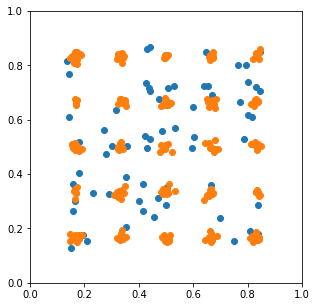

In [12]:
g.train()

In [9]:
temp = g.dataset.sample_train(20)

Dimensionality of discriminator representation: (200, 500)


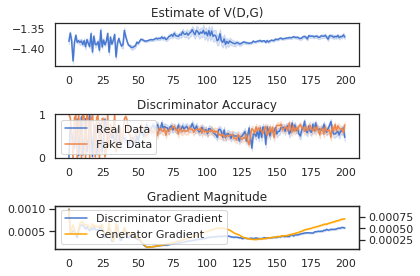

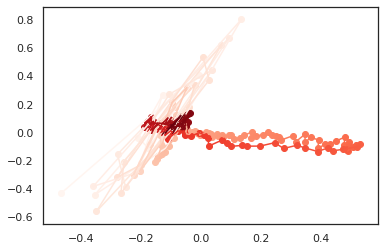

In [13]:
g.make_plots()